Epoch: 0, Loss: 0.6991937160491943
Epoch: 0, Loss: 0.6924907565116882
Epoch: 0, Loss: 0.6820937991142273
Epoch: 0, Loss: 0.6667574048042297
Epoch: 0, Loss: 0.6416953802108765
Epoch: 0, Loss: 0.6145088076591492
Epoch: 0, Loss: 0.6036128401756287
Epoch: 0, Loss: 0.5778195858001709
Epoch: 0, Loss: 0.5298896431922913
Epoch: 0, Loss: 0.5252277255058289
Epoch: 0, Loss: 0.4747220277786255
Epoch: 0, Loss: 0.44836583733558655
Epoch: 0, Loss: 0.3774696886539459
Epoch: 0, Loss: 0.33445224165916443
Epoch: 0, Loss: 0.33386144042015076
Epoch: 0, Loss: 0.2507418394088745
Epoch: 0, Loss: 0.24528977274894714
Epoch: 0, Loss: 0.1803014874458313
Epoch: 0, Loss: 0.09887613356113434
Epoch: 0, Loss: 0.09713342785835266
Epoch: 0, Loss: 0.043914299458265305
Epoch: 0, Loss: 0.042648617178201675
Epoch: 0, Loss: 0.03201794996857643
Epoch: 0, Loss: 0.047999680042266846
Epoch: 0, Loss: 0.005960051901638508
Epoch: 0, Loss: 0.0034313455689698458
Epoch: 0, Loss: 0.003942613489925861
Epoch: 0, Loss: 0.00332966446876525

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

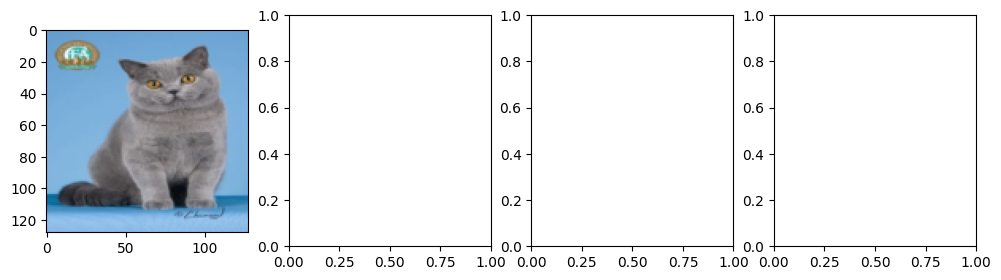

In [5]:
import os
from bs4 import BeautifulSoup
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn as nn
import torch.nn.functional as F

# Disable cuDNN benchmark
import torch.backends.cudnn as cudnn
cudnn.benchmark = False

# Function to read annotation files
def read_ann(directory):
    annotations = os.listdir(directory)
    records = []
    for annot_file in annotations:
        with open(os.path.join(directory, annot_file), 'r') as f:
            file = f.read()
        data = BeautifulSoup(file, "xml")
        objects = data.find_all('object')
        filename = data.find("filename").text
        width = int(data.find("width").text)
        height = int(data.find("height").text)
        for obj in objects:
            class_name = obj.find('name').text
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)
            records.append([filename, class_name, xmin, ymin, xmax, ymax, width, height])
    return records

# Custom dataset class
class CatDogDataset(Dataset):
    def __init__(self, root, annotations, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'images')))
        self.annotations = annotations

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        filename = self.imgs[idx]
        annots = [annot for annot in self.annotations if annot[0] == filename]

        boxes = []
        labels = []
        original_w, original_h = annots[0][6], annots[0][7]
        for annot in annots:
            xmin = annot[2] * 128 / original_w
            ymin = annot[3] * 128 / original_h
            xmax = annot[4] * 128 / original_w
            ymax = annot[5] * 128 / original_h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming single class (e.g., 1 for cat/dog)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms:
            img = self.transforms(img)

        return img, target

# Transformation function
def get_transform(train):
    transforms = []
    transforms.append(T.Resize((128, 128)))
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    return T.Compose(transforms)

# Collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Load annotations
annotations = read_ann('./data/annotations')

# Initialize dataset and dataloader
dataset = CatDogDataset('./data', annotations, transforms=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

dataset_test = CatDogDataset('./data', annotations, transforms=get_transform(train=False))
data_loader_test = DataLoader(dataset_test, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Define the custom Faster R-CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors):
        super(RPN, self).__init__()
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, stride=1, padding=1)
        self.cls_logits = nn.Conv2d(512, num_anchors * 2, kernel_size=1, stride=1)  # Binary classification
        self.bbox_pred = nn.Conv2d(512, num_anchors * 4, kernel_size=1, stride=1)   # Bounding box regression

    def forward(self, x):
        x = F.relu(self.conv(x))
        logits = self.cls_logits(x)
        bbox_pred = self.bbox_pred(x)
        return logits, bbox_pred

class RoIPool(nn.Module):
    def __init__(self, output_size):
        super(RoIPool, self).__init__()
        self.output_size = output_size

    def forward(self, feature_map, proposals_batch):
        pooled_features = []
        _, _, H, W = feature_map.size()
        for proposals in proposals_batch:
            for proposal in proposals:
                x1, y1, x2, y2 = proposal.int()  # Convert to int
                x1, y1 = max(0, x1), max(0, y1)  # Ensure within bounds
                x2, y2 = min(W, x2), min(H, y2)  # Ensure within bounds
                if x2 > x1 and y2 > y1:
                    roi = feature_map[:, :, y1:y2, x1:x2]
                    pooled_feature = F.adaptive_max_pool2d(roi, self.output_size)
                    pooled_features.append(pooled_feature)
        return torch.cat(pooled_features, 0)

class FastRCNNHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNHead, self).__init__()
        self.fc1 = nn.Linear(in_channels, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes)
        self.bbox_pred = nn.Linear(1024, num_classes * 4)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        cls_score = self.cls_score(x)
        bbox_pred = self.bbox_pred(x)
        return cls_score, bbox_pred

class SimpleFasterRCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleFasterRCNN, self).__init__()
        self.backbone = SimpleCNN()
        self.rpn = RPN(in_channels=256, num_anchors=9)
        self.roi_pool = RoIPool(output_size=(7, 7))
        self.head = FastRCNNHead(in_channels=256 * 7 * 7, num_classes=num_classes)

    def forward(self, images, proposals_batch):
        feature_map = self.backbone(images)
        rpn_logits, rpn_bbox_pred = self.rpn(feature_map)
        
        # Simplified assumption that proposals are given for RoI pooling
        roi_pooled_features = self.roi_pool(feature_map, proposals_batch)
        
        cls_score, bbox_pred = self.head(roi_pooled_features)
        return cls_score, bbox_pred

# Instantiate the model
num_classes = 2  # background and object class
model = SimpleFasterRCNN(num_classes=num_classes)

# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Parameters
num_epochs = 10
learning_rate = 0.005
weight_decay = 0.0005
momentum = 0.9

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    for images, targets in data_loader:
        images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Dummy proposals for simplicity, use actual proposals in practice
        batch_size = images.size(0)
        proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(batch_size)]

        cls_score, bbox_pred = model(images, proposals_batch)

        # Compute losses (simplified, just for demonstration)
        loss_cls = F.cross_entropy(cls_score, torch.tensor([1] * cls_score.size(0), dtype=torch.long, device=device))
        loss_bbox = F.smooth_l1_loss(bbox_pred, torch.zeros_like(bbox_pred))

        loss = loss_cls + loss_bbox

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_freq and (epoch % print_freq == 0):
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Evaluate function
def evaluate(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(images.size(0))]
            cls_score, bbox_pred = model(images, proposals_batch)
            # Implement evaluation metrics if needed
            # For now, just ensure the model runs without errors

# Training loop
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)

# Save the model
torch.save(model.state_dict(), 'simple_faster_rcnn_cat_dog.pth')


bbox_pred shape: torch.Size([16, 8])
bbox_pred: tensor([[-1.5343e-03,  6.0136e-04,  1.3256e-03,  8.1662e-04, -4.3242e-03,
          2.7591e-03, -1.9780e-03,  1.9239e-03],
        [ 8.0895e-05,  6.3589e-05, -6.0518e-05,  1.4007e-03, -1.5593e-04,
         -2.4399e-03, -5.3629e-04, -1.7873e-04],
        [-3.3674e-03,  1.2948e-03,  4.0620e-03,  3.1978e-03, -2.5702e-03,
         -4.2278e-05, -2.0378e-03, -1.4207e-04],
        [-1.4531e-03,  5.4314e-04, -5.9668e-04, -2.7069e-04,  4.6251e-04,
         -2.4709e-03, -1.8972e-03,  2.0202e-03],
        [-1.5343e-03,  6.0136e-04,  1.3256e-03,  8.1662e-04, -4.3242e-03,
          2.7591e-03, -1.9780e-03,  1.9239e-03],
        [ 8.0895e-05,  6.3589e-05, -6.0518e-05,  1.4007e-03, -1.5593e-04,
         -2.4399e-03, -5.3629e-04, -1.7873e-04],
        [-3.3674e-03,  1.2948e-03,  4.0620e-03,  3.1978e-03, -2.5702e-03,
         -4.2278e-05, -2.0378e-03, -1.4207e-04],
        [-1.4531e-03,  5.4314e-04, -5.9668e-04, -2.7069e-04,  4.6251e-04,
         -2.4709e

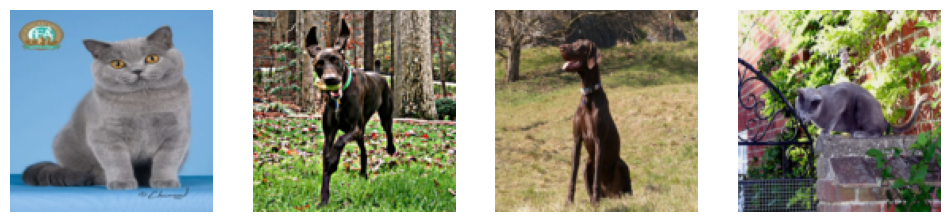

In [11]:
def visualize_predictions(loader, model, device, num_images=4):
    model.eval()
    for images, targets in loader:
        images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
        with torch.no_grad():
            proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(images.size(0))]
            cls_score, bbox_pred = model(images, proposals_batch)
        
        # bbox_pred의 형태와 값을 출력
        print(f'bbox_pred shape: {bbox_pred.shape}')
        print(f'bbox_pred: {bbox_pred}')

        fig, axs = plt.subplots(1, num_images, figsize=(num_images*3, 3))
        for i in range(num_images):
            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
            h, w, _ = img.shape
            # bbox_pred를 반복문에 넣어서 각 박스를 그리도록 합니다.
            if len(bbox_pred.size()) > 1:  # bbox_pred가 0차원 텐서가 아닌 경우만 처리
                for box in bbox_pred[i]:
                    if len(box.size()) == 1 and box.size(0) == 4:  # box가 1차원 텐서이고 크기가 4인 경우만 처리
                        # 예측된 박스 좌표를 이미지 크기에 맞게 조정
                        x1, y1, x2, y2 = box[0].item() * w, box[1].item() * h, box[2].item() * w, box[3].item() * h
                        rect = patches.Rectangle(
                            (x1, y1), x2 - x1, y2 - y1, 
                            linewidth=2, edgecolor='r', facecolor='none'
                        )
                        axs[i].add_patch(rect)
            axs[i].axis('off')
        plt.show()
        break

# Visualize predictions
visualize_predictions(data_loader_test, model, device)


In [23]:
import os
from bs4 import BeautifulSoup
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn as nn
import torch.nn.functional as F

# Disable cuDNN benchmark
import torch.backends.cudnn as cudnn
cudnn.benchmark = False

def read_ann(directory):
    annotations = os.listdir(directory)
    records = []
    for annot_file in annotations:
        with open(os.path.join(directory, annot_file), 'r') as f:
            file = f.read()
        data = BeautifulSoup(file, "xml")
        objects = data.find_all('object')
        filename = data.find("filename").text
        width = int(data.find("width").text)
        height = int(data.find("height").text)
        for obj in objects:
            class_name = obj.find('name').text
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)
            records.append([filename, class_name, xmin, ymin, xmax, ymax, width, height])
    return records

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    return T.Compose(transforms)

# Custom dataset class (with padding and resizing)
class CatDogDataset(Dataset):
    def __init__(self, root, annotations, transforms=None, shape=(256, 256)):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'images')))
        self.annotations = annotations
        self.shape = shape

    def __len__(self):
        return len(self.imgs)

    def _preprocess_image(self, img, bboxes):
        h, w, _ = img.shape
        img = cv2.resize(img, self.shape)  # 리사이즈
        H, W, _ = img.shape  # 리사이즈 후의 크기
        scale_x, scale_y = W / w, H / h  # 스케일링 비율 계산

        scaled_bboxes = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            x1, x2 = x1 * scale_x, x2 * scale_x
            y1, y2 = y1 * scale_y, y2 * scale_y
            scaled_bboxes.append([x1, y1, x2, y2])

        return img, scaled_bboxes

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB
        
        filename = self.imgs[idx]
        annots = [annot for annot in self.annotations if annot[0] == filename]

        boxes = []
        labels = []
        for annot in annots:
            xmin = annot[2]
            ymin = annot[3]
            xmax = annot[4]
            ymax = annot[5]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming single class (e.g., 1 for cat/dog)

        if len(boxes) > 0:
            img, boxes = self._preprocess_image(img, boxes)

        img = (img / 255.).astype(np.float32)
        
        if self.transforms:
            img = Image.fromarray((img * 255).astype(np.uint8))  # To PIL Image
            img = self.transforms(img)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target

# Initialize dataset and dataloader with updated transform
annotations = read_ann('./data/annotations')
dataset = CatDogDataset('./data', annotations, transforms=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

dataset_test = CatDogDataset('./data', annotations, transforms=get_transform(train=False))
data_loader_test = DataLoader(dataset_test, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [24]:
# Define the custom Faster R-CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

class RPN(nn.Module):
    def __init__(self, in_channels, num_anchors):
        super(RPN, self).__init__()
        self.conv = nn.Conv2d(in_channels, 512, kernel_size=3, stride=1, padding=1)
        self.cls_logits = nn.Conv2d(512, num_anchors * 2, kernel_size=1, stride=1)  # Binary classification
        self.bbox_pred = nn.Conv2d(512, num_anchors * 4, kernel_size=1, stride=1)   # Bounding box regression

    def forward(self, x):
        x = F.relu(self.conv(x))
        logits = self.cls_logits(x)
        bbox_pred = self.bbox_pred(x)
        return logits, bbox_pred

class RoIPool(nn.Module):
    def __init__(self, output_size):
        super(RoIPool, self).__init__()
        self.output_size = output_size

    def forward(self, feature_map, proposals_batch):
        pooled_features = []
        _, _, H, W = feature_map.size()
        for proposals in proposals_batch:
            for proposal in proposals:
                x1, y1, x2, y2 = proposal.int()  # Convert to int
                x1, y1 = max(0, x1), max(0, y1)  # Ensure within bounds
                x2, y2 = min(W, x2), min(H, y2)  # Ensure within bounds
                if x2 > x1 and y2 > y1:
                    roi = feature_map[:, :, y1:y2, x1:x2]
                    pooled_feature = F.adaptive_max_pool2d(roi, self.output_size)
                    pooled_features.append(pooled_feature)
        return torch.cat(pooled_features, 0)

class FastRCNNHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNHead, self).__init__()
        self.fc1 = nn.Linear(in_channels, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.cls_score = nn.Linear(1024, num_classes)
        self.bbox_pred = nn.Linear(1024, num_classes * 4)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        cls_score = self.cls_score(x)
        bbox_pred = self.bbox_pred(x)
        return cls_score, bbox_pred

class SimpleFasterRCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleFasterRCNN, self).__init__()
        self.backbone = SimpleCNN()
        self.rpn = RPN(in_channels=256, num_anchors=9)
        self.roi_pool = RoIPool(output_size=(7, 7))
        self.head = FastRCNNHead(in_channels=256 * 7 * 7, num_classes=num_classes)

    def forward(self, images, proposals_batch):
        feature_map = self.backbone(images)
        rpn_logits, rpn_bbox_pred = self.rpn(feature_map)
        
        # Simplified assumption that proposals are given for RoI pooling
        roi_pooled_features = self.roi_pool(feature_map, proposals_batch)
        
        cls_score, bbox_pred = self.head(roi_pooled_features)
        return cls_score, bbox_pred

# Instantiate the model
num_classes = 2  # background and object class
model = SimpleFasterRCNN(num_classes=num_classes)

# Move model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Parameters
num_epochs = 10
learning_rate = 0.005
weight_decay = 0.0005
momentum = 0.9

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    for images, targets in data_loader:
        images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Dummy proposals for simplicity, use actual proposals in practice
        batch_size = images.size(0)
        proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(batch_size)]

        cls_score, bbox_pred = model(images, proposals_batch)

        # Compute losses (simplified, just for demonstration)
        loss_cls = F.cross_entropy(cls_score, torch.tensor([1] * cls_score.size(0), dtype=torch.long, device=device))
        loss_bbox = F.smooth_l1_loss(bbox_pred, torch.zeros_like(bbox_pred))

        loss = loss_cls + loss_bbox

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_freq and (epoch % print_freq == 0):
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

# Evaluate function
def evaluate(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        for images, targets in data_loader:
            images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(images.size(0))]
            cls_score, bbox_pred = model(images, proposals_batch)
            # Implement evaluation metrics if needed
            # For now, just ensure the model runs without errors

# Training loop
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)

# Save the model
torch.save(model.state_dict(), 'simple_faster_rcnn_cat_dog.pth')

Epoch: 0, Loss: 0.6853300929069519
Epoch: 0, Loss: 0.6812148094177246
Epoch: 0, Loss: 0.6689438223838806
Epoch: 0, Loss: 0.6577305197715759
Epoch: 0, Loss: 0.6366750001907349
Epoch: 0, Loss: 0.613074779510498
Epoch: 0, Loss: 0.5937748551368713
Epoch: 0, Loss: 0.5660368800163269
Epoch: 0, Loss: 0.5423601865768433
Epoch: 0, Loss: 0.5178345441818237
Epoch: 0, Loss: 0.4941939115524292
Epoch: 0, Loss: 0.4668232798576355
Epoch: 0, Loss: 0.4223483204841614
Epoch: 0, Loss: 0.37749797105789185
Epoch: 0, Loss: 0.34326767921447754
Epoch: 0, Loss: 0.31831449270248413
Epoch: 0, Loss: 0.27137863636016846
Epoch: 0, Loss: 0.24098588526248932
Epoch: 0, Loss: 0.20396244525909424
Epoch: 0, Loss: 0.14043284952640533
Epoch: 0, Loss: 0.0993388220667839
Epoch: 0, Loss: 0.06597459316253662
Epoch: 0, Loss: 0.059946946799755096
Epoch: 0, Loss: 0.036204490810632706
Epoch: 0, Loss: 0.0236830897629261
Epoch: 0, Loss: 0.02384534850716591
Epoch: 0, Loss: 0.011411856859922409
Epoch: 0, Loss: 0.0071319458074867725
Epo

In [26]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    """
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    xi1 = max(x1, x1_)
    yi1 = max(y1, y1_)
    xi2 = min(x2, x2_)
    yi2 = min(y2, y2_)

    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2_ - x1_ + 1) * (y2_ - y1_ + 1)

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area

    return iou

def evaluate_model(loader, model, device, iou_threshold=0.5):
    model.eval()
    total_iou = 0
    total_images = 0
    num_correct = 0
    num_total = 0
    
    for images, targets in loader:
        images = torch.stack([img.to(device) for img in images])
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(images.size(0))]
            cls_score, bbox_pred = model(images, proposals_batch)
        
        for i in range(len(images)):
            pred_boxes = bbox_pred[i].view(-1, 4).cpu().numpy()
            true_boxes = targets[i]['boxes'].cpu().numpy()

            for pred_box in pred_boxes:
                for true_box in true_boxes:
                    iou = calculate_iou(pred_box, true_box)
                    total_iou += iou
                    num_total += 1
                    if iou >= iou_threshold:
                        num_correct += 1

            total_images += 1

    mean_iou = total_iou / num_total
    accuracy = num_correct / num_total

    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

# Evaluate the model
evaluate_model(data_loader_test, model, device)


Mean IoU: 0.0000
Accuracy: 0.0000


bbox_pred shape: torch.Size([32, 8])
bbox_pred: tensor([[-3.5561e-03, -5.5545e-04, -1.1283e-03,  8.7321e-04, -1.7495e-03,
         -8.1764e-04, -8.8879e-04,  9.9208e-05],
        [ 2.5939e-03, -2.5620e-03,  4.5022e-04, -6.9856e-03,  7.1944e-03,
         -3.7171e-03, -1.1942e-03, -1.9469e-03],
        [-2.0870e-03,  1.2530e-03, -6.0645e-04, -2.5826e-04,  4.6438e-03,
         -1.3594e-03,  3.8980e-03,  5.8619e-03],
        [-1.6734e-03, -2.0082e-03,  9.9924e-04,  3.2051e-03,  3.6243e-03,
          3.7204e-03, -8.3938e-04, -4.3612e-03],
        [ 1.4965e-03, -1.6761e-03, -2.0974e-03,  4.0434e-03, -2.0059e-03,
          1.6338e-03, -1.6259e-03, -2.0095e-03],
        [ 6.9185e-04, -1.9056e-03, -9.1007e-04, -3.6637e-03,  4.0450e-03,
         -5.9898e-04, -6.2918e-04,  1.1165e-03],
        [-5.4509e-04,  3.2401e-04,  8.3078e-04, -2.2882e-03,  1.2330e-03,
         -1.0709e-03, -1.1149e-05,  1.5634e-04],
        [ 1.4178e-04, -3.4560e-04, -1.7070e-03,  2.4148e-04,  1.4347e-04,
          2.1440e

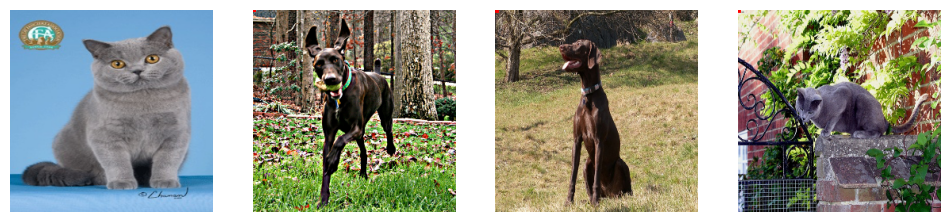

In [25]:
def visualize_predictions(loader, model, device, num_images=4):
    model.eval()
    for images, targets in loader:
        images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
        with torch.no_grad():
            proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(images.size(0))]
            cls_score, bbox_pred = model(images, proposals_batch)
        
        # bbox_pred의 형태와 값을 출력
        print(f'bbox_pred shape: {bbox_pred.shape}')
        print(f'bbox_pred: {bbox_pred}')

        fig, axs = plt.subplots(1, num_images, figsize=(num_images*3, 3))
        for i in range(num_images):
            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
            h, w, _ = img.shape

            # bbox_pred를 반복문에 넣어서 각 박스를 그리도록 합니다.
            if bbox_pred.dim() == 2 and bbox_pred.size(1) % 4 == 0:  # bbox_pred가 2차원 텐서이고 4의 배수 크기인 경우
                boxes = bbox_pred[i].view(-1, 4)  # 4개씩 묶어서 박스로 만듭니다
                for box in boxes:
                    x1, y1, x2, y2 = box[0].item() * w, box[1].item() * h, box[2].item() * w, box[3].item() * h
                    rect = patches.Rectangle(
                        (x1, y1), x2 - x1, y2 - y1, 
                        linewidth=2, edgecolor='r', facecolor='none'
                    )
                    axs[i].add_patch(rect)
            axs[i].axis('off')
        plt.show()
        break

# Visualize predictions
visualize_predictions(data_loader_test, model, device)

bbox_pred shape: torch.Size([32, 8])
bbox_pred: tensor([[-1.6249e-03,  2.1244e-03, -1.7148e-03,  5.0493e-05,  3.9288e-04,
          4.8873e-03, -1.3482e-03, -3.3950e-03],
        [-7.6619e-03,  4.2728e-04,  6.4790e-04,  1.4786e-03,  2.2404e-03,
         -1.8515e-03,  6.3226e-04, -5.0665e-03],
        [ 2.3234e-03,  3.8322e-03, -4.9948e-03,  6.7175e-04, -1.2072e-04,
         -1.4273e-03,  2.6916e-04, -1.0898e-03],
        [-3.6075e-03, -1.5573e-03, -4.5165e-04, -8.0157e-04,  3.5338e-03,
          3.5836e-03,  4.7047e-05,  2.4901e-03],
        [-5.4233e-05,  4.3497e-05,  4.6991e-05, -1.2920e-04,  2.5433e-05,
          4.7352e-05, -1.7327e-04,  1.2539e-04],
        [ 3.7554e-03, -6.1756e-04,  2.5519e-03,  2.9325e-03, -6.7762e-03,
         -1.0251e-04,  9.4651e-04,  1.7881e-03],
        [-5.4233e-05,  4.3497e-05,  4.6991e-05, -1.2920e-04,  2.5433e-05,
          4.7352e-05, -1.7327e-04,  1.2539e-04],
        [-5.4233e-05,  4.3497e-05,  4.6991e-05, -1.2920e-04,  2.5433e-05,
          4.7352e

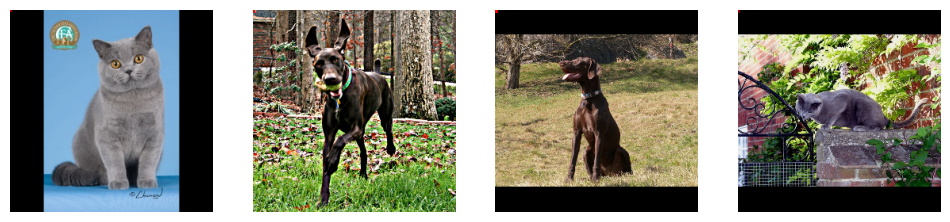

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

def visualize_predictions(loader, model, device, num_images=4):
    model.eval()
    for images, targets in loader:
        images = torch.stack([img.to(device) for img in images])  # Stack images into a single tensor
        with torch.no_grad():
            proposals_batch = [torch.tensor([[10, 10, 50, 50], [30, 30, 70, 70]], dtype=torch.float32).to(device) for _ in range(images.size(0))]
            cls_score, bbox_pred = model(images, proposals_batch)
        
        # bbox_pred의 형태와 값을 출력
        print(f'bbox_pred shape: {bbox_pred.shape}')
        print(f'bbox_pred: {bbox_pred}')

        fig, axs = plt.subplots(1, num_images, figsize=(num_images*3, 3))
        for i in range(num_images):
            img = images[i].permute(1, 2, 0).cpu().numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)
            axs[i].imshow(img)
            h, w, _ = img.shape

            # bbox_pred를 반복문에 넣어서 각 박스를 그리도록 합니다.
            if bbox_pred.dim() == 2 and bbox_pred.size(1) == 8:  # bbox_pred가 2차원 텐서이고 각 요소가 8인 경우
                boxes = bbox_pred[i].view(-1, 4)  # 4개씩 묶어서 박스로 만듭니다
                for box in boxes:
                    x1, y1, x2, y2 = box[0].item() * w, box[1].item() * h, box[2].item() * w, box[3].item() * h
                    rect = patches.Rectangle(
                        (x1, y1), x2 - x1, y2 - y1, 
                        linewidth=2, edgecolor='r', facecolor='none'
                    )
                    axs[i].add_patch(rect)
            axs[i].axis('off')
        plt.show()
        break

# Visualize predictions
visualize_predictions(data_loader_test, model, device)


In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from bs4 import BeautifulSoup

# Function to read annotation files
def read_ann(directory):
    annotations = os.listdir(directory)
    records = []
    for annot_file in annotations:
        with open(os.path.join(directory, annot_file), 'r') as f:
            file = f.read()
        data = BeautifulSoup(file, "xml")
        objects = data.find_all('object')
        filename = data.find("filename").text
        width = int(data.find("width").text)
        height = int(data.find("height").text)
        for obj in objects:
            class_name = obj.find('name').text
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)
            records.append([filename, class_name, xmin, ymin, xmax, ymax, width, height])
    return records

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    return T.Compose(transforms)

# Custom dataset class (with padding and resizing)
class CatDogDataset(Dataset):
    def __init__(self, root, annotations, transforms=None, shape=(256, 256)):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'images')))
        self.annotations = annotations
        self.shape = shape

    def __len__(self):
        return len(self.imgs)

    def _preprocess_image(self, img, bboxes):
        h, w, _ = img.shape
        img = cv2.resize(img, self.shape)  # 리사이즈
        H, W, _ = img.shape  # 리사이즈 후의 크기
        scale_x, scale_y = W / w, H / h  # 스케일링 비율 계산

        scaled_bboxes = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            x1, x2 = x1 * scale_x, x2 * scale_x
            y1, y2 = y1 * scale_y, y2 * scale_y
            scaled_bboxes.append([x1, y1, x2, y2])

        return img, scaled_bboxes

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB
        
        filename = self.imgs[idx]
        annots = [annot for annot in self.annotations if annot[0] == filename]

        boxes = []
        labels = []
        for annot in annots:
            xmin = annot[2]
            ymin = annot[3]
            xmax = annot[4]
            ymax = annot[5]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming single class (e.g., 1 for cat/dog)

        if len(boxes) > 0:
            img, boxes = self._preprocess_image(img, boxes)

        img = (img / 255.).astype(np.float32)
        
        if self.transforms:
            img = Image.fromarray((img * 255).astype(np.uint8))  # To PIL Image
            img = self.transforms(img)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target

# Initialize dataset and dataloader with updated transform
annotations = read_ann('./data/annotations')
dataset = CatDogDataset('./data', annotations, transforms=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

dataset_test = CatDogDataset('./data', annotations, transforms=get_transform(train=False))
data_loader_test = DataLoader(dataset_test, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [2]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import mobilenet_v2

# MobileNet V2를 백본으로 사용하는 Faster R-CNN 모델 정의
def get_model(num_classes):
    # pretrained=True로 미리 학습된 MobileNet V2 모델 로드
    backbone = mobilenet_v2(pretrained=True).features
    backbone.out_channels = 1280

    # RPN의 앵커 생성기 정의
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),) * 5)

    # ROI 풀러 정의
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)

    # Faster R-CNN 모델 정의
    model = FasterRCNN(backbone,
                       num_classes=num_classes,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)

    return model

# GPU가 사용 가능한지 확인
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 모델 초기화
num_classes = 2  # 배경 + 1 클래스
model = get_model(num_classes)
model.to(device)

# 옵티마이저 설정
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# 학습 루프
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print(f"Epoch #{epoch} iter #{i}: loss: {losses.item()}")
        i += 1

    print(f"Epoch #{epoch} completed")

# 모델 저장
torch.save(model.state_dict(), 'fasterrcnn_mobilenet_v2_model.pth')



c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\admin\anaconda3\envs\DL\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\na

Epoch #0 iter #0: loss: 1.5023831129074097
Epoch #0 iter #10: loss: 0.4632279872894287


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# IoU 계산 함수
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    xi1 = max(x1, x1_)
    yi1 = max(y1, y1_)
    xi2 = min(x2, x2_)
    yi2 = min(y2, y2_)

    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2_ - x1_ + 1) * (y2_ - y1_ + 1)

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area

    return iou

# 모델 평가 함수
def evaluate_model(loader, model, device, iou_threshold=0.5):
    model.eval()
    total_iou = 0
    total_images = 0
    num_correct = 0
    num_total = 0
    
    for images, targets in loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            outputs = model(images)
        
        for i in range(len(images)):
            pred_boxes = outputs[i]['boxes'].cpu().numpy()
            true_boxes = targets[i]['boxes'].cpu().numpy()

            for pred_box in pred_boxes:
                for true_box in true_boxes:
                    iou = calculate_iou(pred_box, true_box)
                    total_iou += iou
                    num_total += 1
                    if iou >= iou_threshold:
                        num_correct += 1

            total_images += 1

    mean_iou = total_iou / num_total
    accuracy = num_correct / num_total

    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

# 모델 시각화 함수
def visualize_predictions(loader, model, device, num_images=4):
    model.eval()
    images, targets = next(iter(loader))
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    
    with torch.no_grad():
        outputs = model(images)
    
    fig, axs = plt.subplots(1, num_images, figsize=(num_images*5, 5))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img * 255).astype(np.uint8)
        axs[i].imshow(img)
        h, w, _ = img.shape
        
        # 실제 바운딩 박스 그리기
        for box in targets[i]['boxes'].cpu().numpy():
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none')
            axs[i].add_patch(rect)
        
        # 예측된 바운딩 박스 그리기
        for box in outputs[i]['boxes'].cpu().numpy():
            x1, y1, x2, y2 = box
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            axs[i].add_patch(rect)
        
        axs[i].axis('off')
    plt.show()

# Evaluate the model
evaluate_model(data_loader_test, model, device)

# Visualize predictions
visualize_predictions(data_loader_test, model, device)



In [ ]:
# visualize train image's bbox
def visualize_data(loader, batch_size):
    for i, (imgs, targets) in enumerate(loader):
        fig, axs = plt.subplots(1, batch_size, figsize=(batch_size*3, 3))
        for j in range(batch_size):
            img = imgs[j].permute(1, 2, 0).numpy()
            img = (img * 0.5 + 0.5) * 255
            img = img.astype(np.uint8)
            axs[j].imshow(img)
            for box in targets[j]['boxes']:
                rect = patches.Rectangle(
                    (box[0], box[1]), box[2] - box[0], box[3] - box[1], 
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                axs[j].add_patch(rect)
            axs[j].axis('off')
        plt.show()
        if i > 3:
            break

# Visualize some data
visualize_data(data_loader, batch_size=4)

In [21]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from bs4 import BeautifulSoup
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import mobilenet_v2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2  # 배경 포함 클래스 수
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 모델 불러오기
state_dict = torch.load("fasterrcnn_resnet50_fpn.pth")
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [6]:
import cv2
def overlay_instances(img, prediction, threshold=0.8):
    label_dict = {0: 'cat', 1: 'dog'}
    ori_img = img.mul(255).permute(1,2,0).byte().numpy() # Tensor * 255, Convert RGB -> BGR, Tensor to numpy
    for idx in range(len(prediction[0]['boxes'])):
        score = prediction[0]['scores'][idx].cpu().detach().numpy().item() # detach() : Generation of tensors that do not propagate gradients from existing sensors
        if score < threshold:
            continue
        box = x1,y1,x2,y2 = prediction[0]['boxes'][idx].cpu().detach().numpy()
        label = prediction[0]['labels'][idx].cpu().detach().numpy().item()
        print(x1,y1, x2, y2)
        cv2.rectangle(ori_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)
        cv2.rectangle(ori_img, (int(x1), int(y1)), (int(x1+60), int(y1+20)), (255,0,0),-1)
        cv2.putText(ori_img, label_dict[label], (int(x1), int(y1+15)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), thickness=1)
    return Image.fromarray(ori_img)

In [23]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to read annotation files
def read_ann(directory):
    annotations = os.listdir(directory)
    records = []
    for annot_file in annotations:
        with open(os.path.join(directory, annot_file), 'r') as f:
            file = f.read()
        data = BeautifulSoup(file, "xml")
        objects = data.find_all('object')
        filename = data.find("filename").text
        width = int(data.find("width").text)
        height = int(data.find("height").text)
        for obj in objects:
            class_name = obj.find('name').text
            xmin = int(obj.find('bndbox').find('xmin').text)
            ymin = int(obj.find('bndbox').find('ymin').text)
            xmax = int(obj.find('bndbox').find('xmax').text)
            ymax = int(obj.find('bndbox').find('ymax').text)
            records.append([filename, class_name, xmin, ymin, xmax, ymax, width, height])
    return records

class CatDogDataset(Dataset):
    def __init__(self, root, annotations, transforms=None, shape=(256, 256)):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, 'images')))
        self.annotations = annotations
        self.shape = shape

    def __len__(self):
        return len(self.imgs)

    def _preprocess_image(self, img, bboxes):
        h, w, _ = img.shape
        img = cv2.resize(img, self.shape)  # 리사이즈
        H, W, _ = img.shape  # 리사이즈 후의 크기
        scale_x, scale_y = W / w, H / h  # 스케일링 비율 계산

        scaled_bboxes = []
        for bbox in bboxes:
            x1, y1, x2, y2 = bbox
            x1, x2 = x1 * scale_x, x2 * scale_x
            y1, y2 = y1 * scale_y, y2 * scale_y
            scaled_bboxes.append([x1, y1, x2, y2])

        return img, scaled_bboxes

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        img = cv2.imread(img_path)[..., ::-1]  # Convert BGR to RGB
        
        filename = self.imgs[idx]
        annots = [annot for annot in self.annotations if annot[0] == filename]

        boxes = []
        labels = []
        for annot in annots:
            xmin = annot[2]
            ymin = annot[3]
            xmax = annot[4]
            ymax = annot[5]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Assuming single class (e.g., 1 for cat/dog)

        if len(boxes) > 0:
            img, boxes = self._preprocess_image(img, boxes)

        img = (img / 255.).astype(np.float32)
        
        if self.transforms:
            img = Image.fromarray((img * 255).astype(np.uint8))  # To PIL Image
            img = self.transforms(img)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target
    
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    return T.Compose(transforms)
batch_size=4
annotations = read_ann('./data/annotations')
dataset = CatDogDataset('./data', annotations, transforms=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

dataset_test = CatDogDataset('./data', annotations, transforms=get_transform(train=False))
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

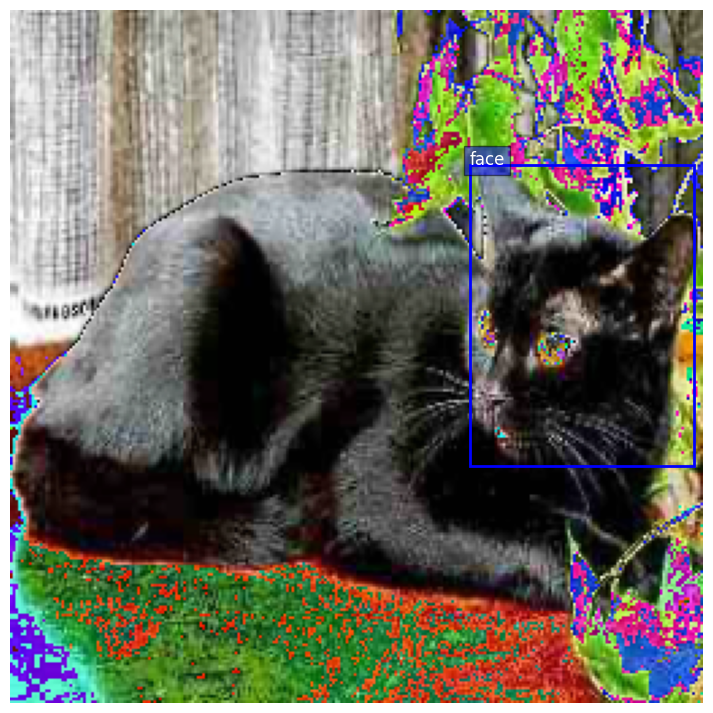

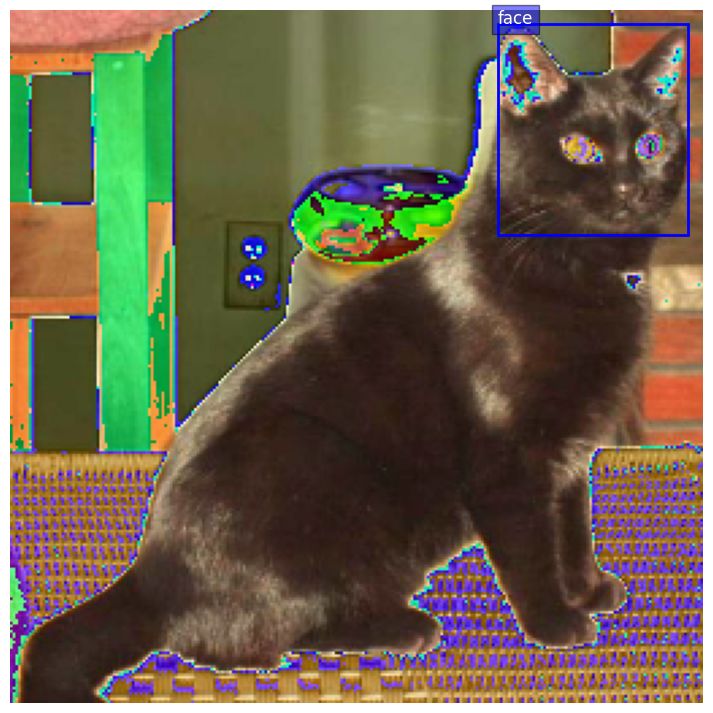

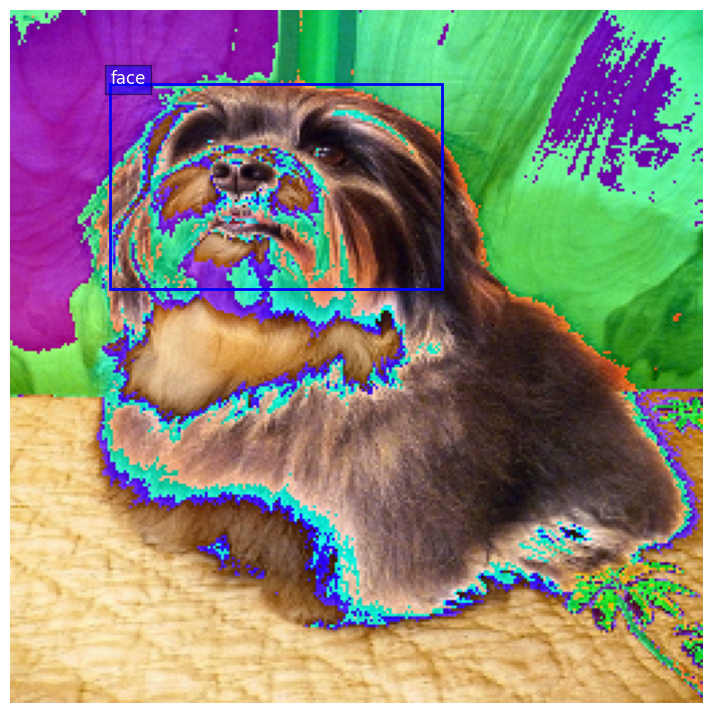

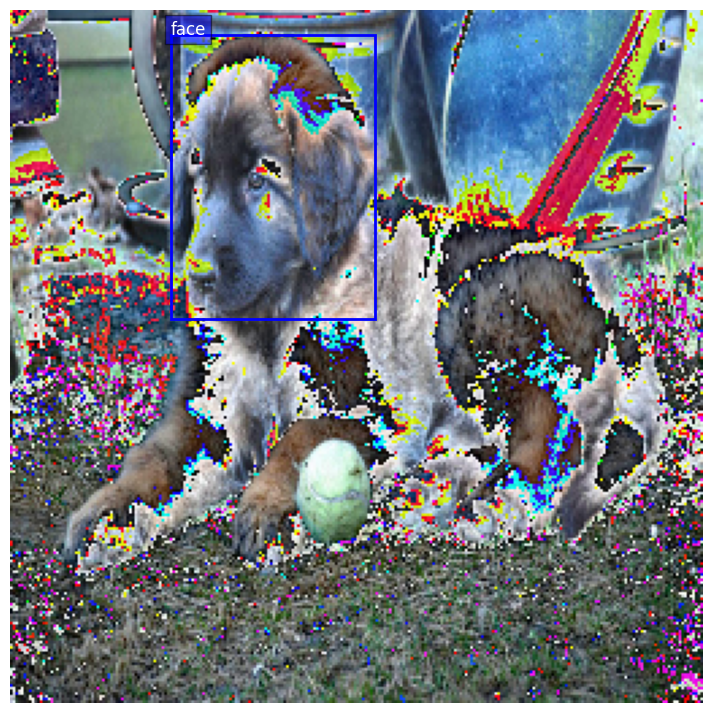

In [24]:
def visualize_predictions(image, predictions, threshold=0.5):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, score, label in zip(predictions['boxes'].cpu(), predictions['scores'].cpu(), predictions['labels'].cpu()):
        if score >= threshold:
            x1, y1, x2, y2 = box
            width, height = x2 - x1, y2 - y1

            # 바운딩 박스 그리기
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='b', facecolor='none')
            ax.add_patch(rect)

            # 레이블 그리기
            label_text = 'face' if label == 1 else 'unknown'
            ax.text(x1, y1, label_text, bbox=dict(facecolor='blue', alpha=0.5), fontsize=12, color='white')

    plt.axis('off')
    plt.show()

# 데이터 로더를 사용하여 예측 및 시각화
for images, targets in data_loader_test:
    images = list(img.to(device) for img in images)
    with torch.no_grad():
        outputs = model(images)

    for image, target, output in zip(images, targets, outputs):
        # 이미지 텐서를 PIL 이미지로 변환
        image = image.permute(1, 2, 0).cpu().numpy()
        image = (image * 255).astype(np.uint8)
        image = Image.fromarray(image)

        # 예측 결과 시각화
        visualize_predictions(image, output)

    break  # 첫 번째 배치만 시각화